In [18]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import joblib

plt.style.use('seaborn-darkgrid')

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,precision_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [19]:
def cleanDataFunction(csvfileName):
  #Reading Data
  df = pd.read_csv(csvfileName)
  
  print(f"Data has {df.shape[0]} Rows and {df.shape[1]} Features")
 
  df.info() #all Dtype are float64
  df.describe()
  
  df = df.astype('int') #convert the data to int type because Integer arithmetic is faster
  df.isna().sum()

  print('###### BEFORE ######')
  print(df.duplicated().value_counts())# Count of duplicated Rows

  duplicates = df[df.duplicated()]
  print("Duplicate Rows : ",len(duplicates))
  print(duplicates['Diabetes_binary'].value_counts())

  df = df.drop_duplicates(subset=None, keep="first", inplace=False) #because the data is unbalanced

  print('###### AFTER ######')
  print(df.duplicated().value_counts())

  print('###### AMOUT OF ZEROS AND ONES ######')
  sns.countplot(x='Diabetes_binary',data=df)
  print(df['Diabetes_binary'].value_counts(normalize=True)*100)
    
  return df

In [20]:
def removeUnneccessaryColumns(df):
  #Droping unnecessary columns
  newData  = df.copy()
  newData.drop(['Education','Income'], axis = 1, inplace=True)
  newData.to_csv('DataWithColumnsDropped.csv')
  newData.columns
  return newData

In [21]:
#correlation
def featureSelectionCorrelation(df):
  plt.figure(figsize = (10,6))
  sns.heatmap(df.corr(), vmax = 0.9, square = True)
  plt.title("Correlations")
  # plt.show()

  #Feature selection
  correlation = df.corr()
  updatedData = pd.DataFrame()
  cnt = 0
  for i in range (len(correlation['Diabetes_binary'])):
      if abs(correlation['Diabetes_binary'][i]) >= 0.05:
          myColumn = df[df.columns[i] ]
          updatedData.insert(cnt,df.columns[i],myColumn)
          cnt = cnt+1
  return updatedData


In [22]:
def main(classifier ,X_train, X_test, y_train, y_test):
  y_train_pred = classifier.predict(X_train)
  y_test_pred = classifier.predict(X_test)

  #Training Data Set
  print("\n-----------TRAINING DATA-----------")
  AccScore = accuracy_score(y_train, y_train_pred)
  F1Score=f1_score(y_train, y_train_pred,average='weighted')
  PrecisionScore = precision_score(y_train, y_train_pred, average='weighted')
  print("Accuracy Score: ",AccScore*100)
  print('Precision Score is : ', PrecisionScore*100)
  print("F1-Score: ",F1Score*100)

  CM = confusion_matrix(y_train, y_train_pred)
  print('Confusion Matrix is : \n', CM)
  #drawing confusion matrix
  plt.figure(figsize = (8,6))
  sns.heatmap(CM, center = True, fmt = ".0f", cmap = 'viridis')
  plt.show()


  print("\n-----------TESTING DATA-----------")
  #Testing Data Set
  AccScore = accuracy_score(y_test, y_test_pred)
  F1Score=f1_score(y_test, y_test_pred,average='weighted')
  PrecisionScore = precision_score(y_test, y_test_pred, average='weighted')
  print("Accuracy Score: ",AccScore*100)
  print('Precision Score is : ', PrecisionScore*100)
  print("F1-Score: ",F1Score*100)

  CM = confusion_matrix(y_test, y_test_pred)
  print('Confusion Matrix is : \n', CM)
  # drawing confusion matrix
  plt.figure(figsize = (8,6))
  sns.heatmap(CM, center = True, fmt = ".0f", cmap = 'viridis')
  plt.show()

In [23]:
#Fitting Logistic Regression Model
def logisticModelFunction(index,X_train, X_test, y_train, y_test):
  classifier = LogisticRegression(C= 100, random_state= 0)
  classifier.fit(X_train, y_train)
  main(classifier ,X_train, X_test, y_train, y_test)
  
  joblib.dump(classifier, "LogisticModel"+index+".pkl")
  
  print("\nMODEL PREDICTION")
  my_model_loaded = joblib.load("LogisticModel"+index+".pkl")
  print(my_model_loaded.predict(X_test)[0:20])

In [24]:
#for Decision tree it returns the importance of each feature on the model
def Sort_Tuple(tup):
      return(sorted(tup, key = lambda x: x[1],reverse=True)) 

In [25]:
#Fitting Decision Tree Model
def decisionModelFunction(index,X_train, X_test, y_train, y_test,X):
  classifier = DecisionTreeClassifier(criterion= 'entropy')
  classifier = classifier.fit(X_train,y_train)
  main(classifier ,X_train, X_test, y_train, y_test)
  print('\n-----------------------------------------------\n')

  fun=lambda row: np.round((row * 100),2)
  features = fun(classifier.feature_importances_)
  
  print(pd.DataFrame(Sort_Tuple(list(zip(X.columns,features))),columns=['Feature', 'Importance (%)']))

  joblib.dump(classifier, "DecisionModel"+index+".pkl")
  
  print("\nMODEL PREDICTION")
  my_model_loaded = joblib.load("DecisionModel"+index+".pkl")
  print(my_model_loaded.predict(X_test)[0:20])


In [26]:
#Fitting Svm Model
def svmModelFunction (index,X_train, X_test, y_train, y_test):
  classifier = LinearSVC()
  classifier.fit(X_train, y_train)
  main(classifier ,X_train, X_test, y_train, y_test)
  joblib.dump(classifier, "svmModel"+index+".pkl")

  print("\nMODEL PREDICTION")
  my_model_loaded = joblib.load("svmModel"+index+".pkl")
  print(my_model_loaded.predict(X_test)[0:20])

In [27]:
def naiveBayesFunction(index,X_train, X_test, y_train, y_test):
  classifier = GaussianNB()
  classifier.fit(X_train, y_train)
  main(classifier,X_train, X_test, y_train, y_test)

  joblib.dump(classifier, "naive_bayesModel"+index+".pkl")
  
  print("\nMODEL PREDICTION")
  my_model_loaded = joblib.load("naive_bayesModel"+index+".pkl")
  print(my_model_loaded.predict(X_test)[0:20])

In [28]:

def randomForestFunction(index,X_train, X_test, y_train, y_test):
  classifier = RandomForestClassifier(random_state=10)

  classifier.fit(X_train, y_train)
  main(classifier,X_train, X_test, y_train, y_test)

  joblib.dump(classifier, "RandomForestClassifierModel"+index+".pkl")
  
  print("\nMODEL PREDICTION")
  my_model_loaded = joblib.load("RandomForestClassifierModel"+index+".pkl")
  print(my_model_loaded.predict(X_test)[0:20])

In [29]:


def bonusFunction(index,X_train, X_test, y_train, y_test):
 grid_models = [(LogisticRegression(),[{'C':[0.25,0.5,0.75,1,10,100,1000],'random_state':[0]}]), 
               (DecisionTreeClassifier(),[{'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150],'random_state':[0]}])
              #  ,(SVC(),[{'C': [0.1, 1, 10, 100, 1000],'gamma': [0.25,0.5,0.75,1,10,100],'kernel': ['rbf']}])
                ]

 for i,j in grid_models:
    grid = GridSearchCV(estimator=i,param_grid = j, scoring = 'accuracy',cv=2)
    grid.fit(X_train, y_train)
    best_accuracy = grid.best_score_
    best_param = grid.best_params_
    print('{}:\nBest Accuracy : {:.2f}%'.format(i,best_accuracy*100))
    print('Best Parameters : ',best_param)
    print('')
    print('----------------')
    print('')

In [30]:
def modelCreationFunction(index,df):
    
  #OverSampling
  X = df.drop(['Diabetes_binary'],axis=1)
  y = df['Diabetes_binary']
  oversample = SMOTE()
  X, y = oversample.fit_resample(X, y)

  # Splitting data into training and test set:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  
  # Creating StandardScaler instance
  sc = StandardScaler()
  # Fitting Standard Scaller
  X_train = sc.fit_transform(X_train)
  # Scaling data
  X_test = sc.transform(X_test)

  print("\n#Logistic Model#",index)
  logisticModelFunction(index,X_train, X_test, y_train, y_test)
  print("\n#Decision Model#",index)
  decisionModelFunction(index,X_train, X_test, y_train, y_test,X)
  print("\n#svm Model#",index)
  svmModelFunction (index,X_train, X_test, y_train, y_test)
  print("\n#naiveBayes Model#",index)
  naiveBayesFunction (index,X_train, X_test, y_train, y_test)
  print("\n#Random Forest Model#",index)
  randomForestFunction (index,X_train, X_test, y_train, y_test)
  print("\n#Compination Between Algorithms And Show Best Hyperparameter#",index)
  bonusFunction(index,X_train, X_test, y_train, y_test)


Data has 253680 Rows and 22 Features
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth        

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4


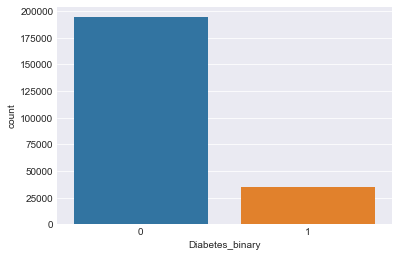

In [31]:
df = pd.DataFrame()
df = cleanDataFunction('D:/ai project/diabetes_binary_health_indicators_BRFSS2015.csv')
df.head()




#Logistic Model# 1

-----------TRAINING DATA-----------
Accuracy Score:  72.6607138837889
Precision Score is :  72.6845921634837
F1-Score:  72.65326677358811
Confusion Matrix is : 
 [[110395  45052]
 [ 39974 115582]]


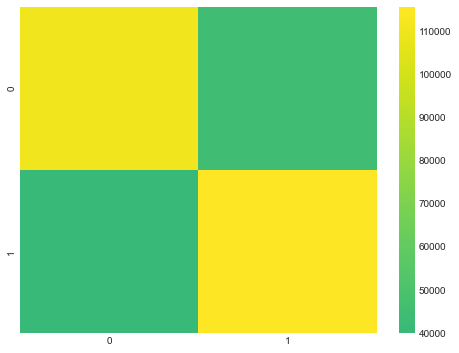


-----------TESTING DATA-----------
Accuracy Score:  72.39263803680981
Precision Score is :  72.4086751195974
F1-Score:  72.38850778351393
Confusion Matrix is : 
 [[27694 11236]
 [10229 28592]]


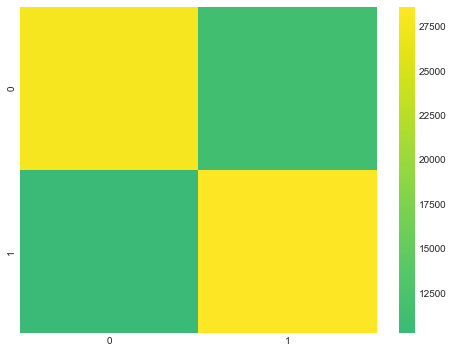


MODEL PREDICTION
[0 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1]

#Decision Model# 1

-----------TRAINING DATA-----------
Accuracy Score:  99.15209821127128
Precision Score is :  99.15248202107757
F1-Score:  99.15209613680739
Confusion Matrix is : 
 [[153911   1536]
 [  1101 154455]]


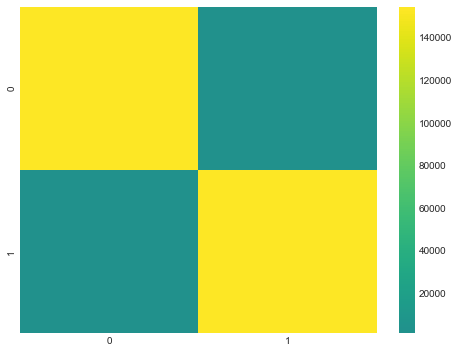


-----------TESTING DATA-----------
Accuracy Score:  80.82982855525974
Precision Score is :  81.16694542358232
F1-Score:  80.77966777248561
Confusion Matrix is : 
 [[29464  9466]
 [ 5439 33382]]


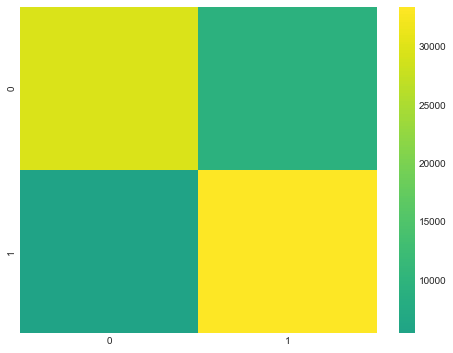


-----------------------------------------------

                 Feature  Importance (%)
0                    BMI           16.08
1                    Age           13.27
2                GenHlth            9.85
3                 Income            9.69
4               PhysHlth            8.37
5              Education            6.86
6               MentHlth            6.67
7               HighChol            3.50
8                 HighBP            3.42
9                    Sex            3.42
10               Veggies            2.91
11                Smoker            2.56
12                Fruits            2.41
13          PhysActivity            2.18
14              DiffWalk            1.83
15  HeartDiseaseorAttack            1.74
16     HvyAlcoholConsump            1.62
17           NoDocbcCost            1.08
18         AnyHealthcare            1.02
19                Stroke            0.81
20             CholCheck            0.71

MODEL PREDICTION
[1 1 1 0 0 1 1 0 1 1 1 0 0 0 0

C:\Users\Maria Tawfek\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



-----------TRAINING DATA-----------
Accuracy Score:  72.63402603833403
Precision Score is :  72.66577721714465
F1-Score:  72.62414933793245
Confusion Matrix is : 
 [[109966  45481]
 [ 39628 115928]]


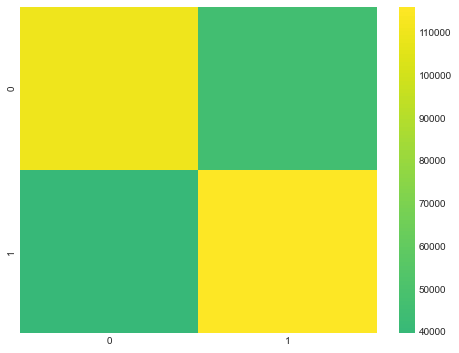


-----------TESTING DATA-----------
Accuracy Score:  72.42221964990804
Precision Score is :  72.44501751566143
F1-Score:  72.41618311468004
Confusion Matrix is : 
 [[27606 11324]
 [10118 28703]]


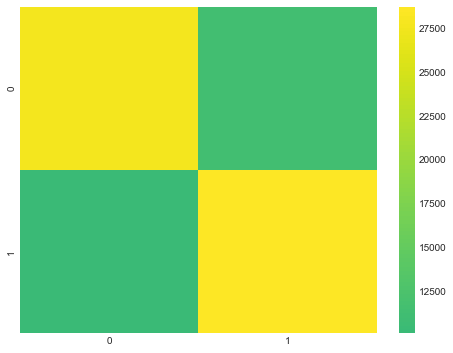


MODEL PREDICTION
[0 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1]

#naiveBayes Model# 1

-----------TRAINING DATA-----------
Accuracy Score:  69.96877843622087
Precision Score is :  72.02185188411956
F1-Score:  69.24941331014591
Confusion Matrix is : 
 [[ 84992  70455]
 [ 22943 132613]]


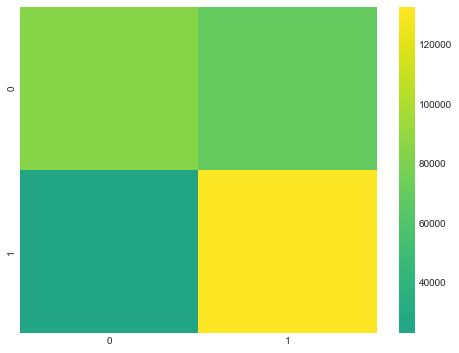


-----------TESTING DATA-----------
Accuracy Score:  69.90392406528534
Precision Score is :  71.88800586076131
F1-Score:  69.21681309852454
Confusion Matrix is : 
 [[21394 17536]
 [ 5864 32957]]


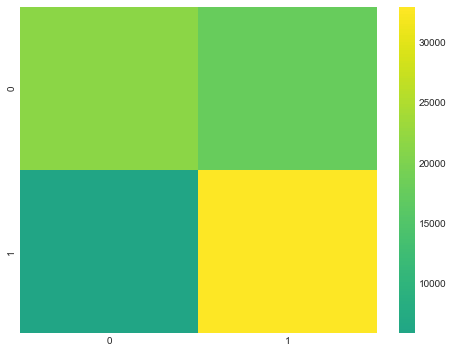


MODEL PREDICTION
[1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1]

#Random Forest Model# 1

-----------TRAINING DATA-----------
Accuracy Score:  99.15177667096458
Precision Score is :  99.1554899428372
F1-Score:  99.15175934818626
Confusion Matrix is : 
 [[153452   1995]
 [   643 154913]]


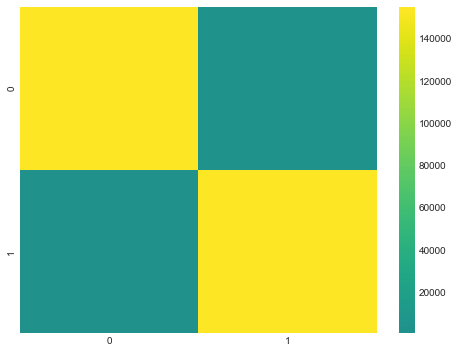


-----------TESTING DATA-----------
Accuracy Score:  85.68635773173335
Precision Score is :  85.92122509168834
F1-Score:  85.6638911072375
Confusion Matrix is : 
 [[31799  7131]
 [ 3998 34823]]


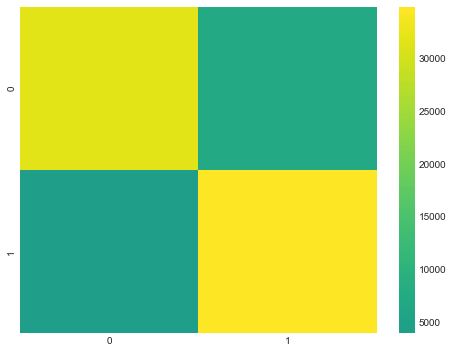


MODEL PREDICTION
[1 0 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1]

#Compination Between Algorithms And Show Best Hyperparameter# 1
LogisticRegression():
Best Accuracy : 72.66%
Best Parameters :  {'C': 0.25, 'random_state': 0}

----------------

DecisionTreeClassifier():
Best Accuracy : 76.17%
Best Parameters :  {'criterion': 'entropy', 'max_depth': 50, 'random_state': 0}

----------------



In [32]:
modelCreationFunction('1',df)

In [33]:
# df = removeUnneccessaryColumns(df)
# modelCreationFunction('2',df)


In [34]:
# df = featureSelectionCorrelation(df)
# modelCreationFunction('3',df)
